# IIP Iceberg Sighting Database Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [5]:
rcParams['figure.figsize'] = (6, 6)

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

# import matplotlib.font_manager
# import os
# fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontList.json"))

# fm.findfont("serif", rebuild_if_missing=False)

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'

## Getting the Data

In [6]:
url = lambda year: f'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G00807/IIP_{year}IcebergSeason.csv'

def convert_str_column_to_timestamp_column(df, *column_names):
    for column_name in column_names:
        df[column_name] = pd.to_datetime(df[column_name])
    return df


def convert_float_column_to_int_column(df, *column_names, drop_nan_rows=True):
    for column_name in column_names:
        try:
            df[column_name] = df[column_name].astype(int)
        except ValueError:
            if drop_nan_rows:
                df = df.dropna(subset=[column_name]).reset_index(drop=True)
                df[column_name] = df[column_name].astype(int)
            else:
                raise
    return df

def create_timedelta_column(df, time_column_name, timedelta_column_name):
    df[time_column_name] = df[time_column_name].astype(str).str.zfill(4)
    df[timedelta_column_name] = df[time_column_name].str[0:2] + ':' + df[time_column_name].str[2:4] + ':00'
    df[timedelta_column_name] = pd.to_timedelta(df[timedelta_column_name])
    return df

def create_datetime_column(df, date_column_name, timedelta_column_name, datetime_column_name):
    df[datetime_column_name] = df[date_column_name] + df[timedelta_column_name]
    return df

def get_dataframe(url):
    
    df = pd.read_csv(url)
    df = convert_str_column_to_timestamp_column(df, 'SIGHTING_DATE')
    df = convert_float_column_to_int_column(df, 'ICEBERG_NUMBER', 'SIGHTING_TIME')
    df = create_timedelta_column(df, 'SIGHTING_TIME', 'SIGHTING_TIMEDELTA')
    df = create_datetime_column(df, 'SIGHTING_DATE', 'SIGHTING_TIMEDELTA', 'SIGHTING_DATETIME')
    
    return df

In [7]:
year = 2015

df = get_dataframe(url(year))

df.head(3)

,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,SIGHTING_TIMEDELTA,SIGHTING_DATETIME
0,2015,1,2014-11-21,1639,59.98,-63.44,VIS,GEN,GEN,GCFR,16:39:00,2014-11-21 16:39:00
1,2015,1,2014-12-13,2138,58.32,-61.18,SAT-HIGH,RAD,RAD,RSA2,21:38:00,2014-12-13 21:38:00
2,2015,2,2014-11-29,2147,58.57,-60.53,SAT-HIGH,RAD,RAD,RSA2,21:47:00,2014-11-29 21:47:00


## Analyzing the Data

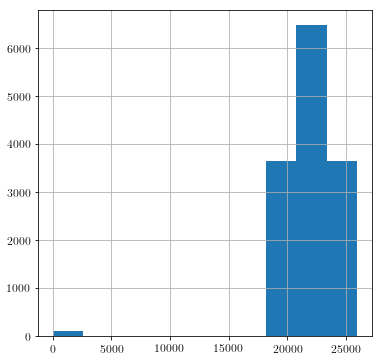

In [8]:
df['ICEBERG_NUMBER'].hist()

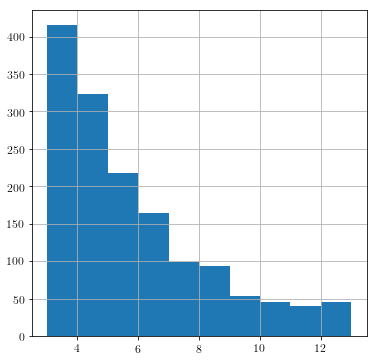

In [9]:
df['ICEBERG_NUMBER'].value_counts().loc[df['ICEBERG_NUMBER'].value_counts() > 2].hist(bins=[i for i in range(3, 14)])

## Plot Bar Graph of Annual Total Per Year

In [10]:
df['ICEBERG_NUMBER'].nunique()

6031

In [11]:
years = [year for year in range(2002, 2018)]
iceberg_total_by_year = {}

for year in years:
    temp_df = get_dataframe(url(year))
    temp_iceberg_total = temp_df['ICEBERG_NUMBER'].nunique()
    iceberg_total_by_year[f'{year}'] = temp_iceberg_total

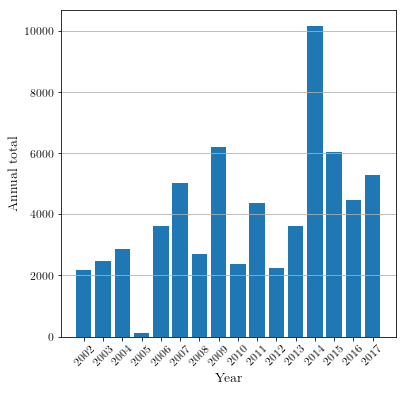

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
plt.bar(iceberg_total_by_year.keys(), iceberg_total_by_year.values())
plt.grid(b=True, which='major', axis='y')
#plt.title('Annual Total of Icebergs by Year')
plt.ylabel('Annual total')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.savefig('plots/annual-total-icebergs-by-year.pdf')
plt.show()

## Basemap or Cartopy?

**Note: Basemap is deprecated and barely maintained anymore.**

In [16]:
def get_mercator_basemap(min_lon, max_lon, min_lat, max_lat):
    
    plt.figure(figsize=(10,8))

    num_ticks = 5
    lat_pad = abs(min_lat - max_lat)/num_ticks
    lon_pad = abs(min_lon - max_lon)/num_ticks

    # instantiate Basemap object with mercator projection
    m = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
                resolution = 'l', area_thresh = 0.1,
                llcrnrlon = min_lon - lon_pad,
                llcrnrlat = min_lat - lat_pad,
                urcrnrlon = max_lon + lon_pad,
                urcrnrlat = max_lat + lat_pad)
    
    m.plot(df['SIGHTING_LONGITUDE'], df['SIGHTING_LATITUDE'])

    # parallels are lines of latitude, meridians are lines of longitude
    parallels = np.round(np.arange(min_lat, max_lat + lat_pad, lat_pad), 2)
    meridians = np.round(np.arange(min_lon, max_lon + lon_pad, lon_pad), 2)

    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,False,False])
    mers = m.drawmeridians(meridians,labels=[False,False,False,True])
    for mer in mers:
        try:
            mers[mer][1][0].set_rotation(90)
        except:
            pass

    # make the land pretty
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='coral')
    m.drawmapboundary()
    
    return m

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


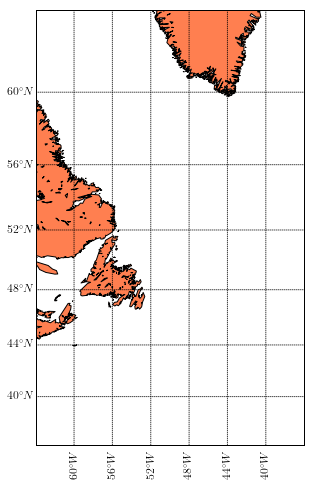

In [17]:
get_mercator_basemap(-60, -40, 40, 60)

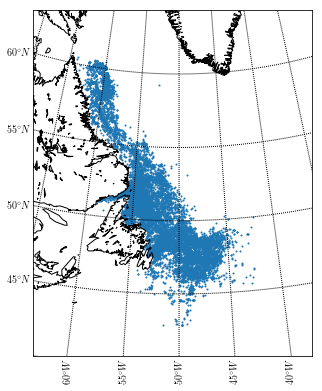

In [21]:
# create figure and axes instances
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=-50, lat_0=50.,lat_ts=45.,
                resolution = 'l', area_thresh = 0.1,
                llcrnrlon = -63,
                llcrnrlat = 40,
                urcrnrlon = -30,
                urcrnrlat = 63)

m.drawcoastlines()

# draw parallels.
parallels = np.arange(0.,90,5.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)

# draw meridians
meridians = np.arange(0.,360.,5.)
meridians = m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
for meridian in meridians:
    try:
        meridians[meridian][1][0].set_rotation(90)
    except:
        pass
    
# plot sample data
lons, lats = m(df['SIGHTING_LONGITUDE'].values, df['SIGHTING_LATITUDE'].values)
m.scatter(lons, lats, s=1)

#plt.title('Iceberg Observations, 2015')

plt.savefig('plots/iceberg-observations-2015.pdf', bbox_inches='tight')
    
plt.show()

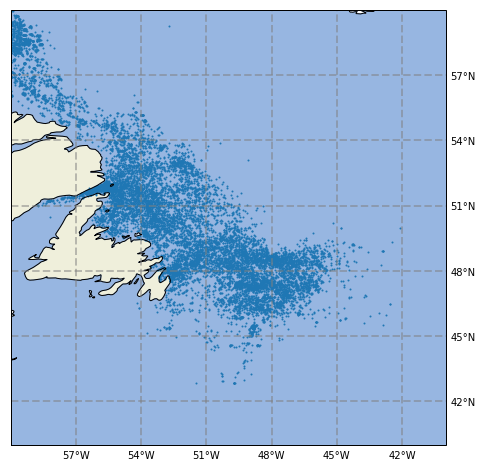

In [83]:
import cartopy.crs as ccrs
import cartopy.feature as cpf
import cartopy.mpl.gridliner as cgl

def make_cartopy_plot():

    ax = plt.figure(figsize=(10, 8)).gca(projection=ccrs.PlateCarree())

    ax.add_feature(cpf.LAND)
    ax.add_feature(cpf.OCEAN.with_scale('50m'))
    ax.add_feature(cpf.COASTLINE.with_scale('50m'))
    #ax.add_feature(cpf.BORDERS, linestyle=':')
    #ax.add_feature(cpf.LAKES, alpha=0.5)
    #ax.add_feature(cpf.RIVERS)

    
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = False
    #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = cgl.LONGITUDE_FORMATTER
    gl.yformatter = cgl.LATITUDE_FORMATTER
    
    ax.set_extent([-60, -40, 40, 60], ccrs.PlateCarree())
    
    ax.scatter(df['SIGHTING_LONGITUDE'], df['SIGHTING_LATITUDE'], s=1)

make_cartopy_plot()
plt.show()